Get Data from URL, cleanse the data, and write data to 'lyrics.txt' file

In [44]:
import requests
from bs4 import BeautifulSoup
import re
import os
import codecs

os.remove("lyrics.txt")
url = 'https://stixoi.info/stixoi.php?info=Lyrics&act=index&sort=alpha&singer_id=1820'
page = requests.get(url)
soup = BeautifulSoup(page.content, 'html.parser')

f = open('lyrics.txt', 'w', encoding='utf-8')
tempsoup = soup.find_all('td', class_='row1') 
for i in range(1, 622, 9):
    link = str(tempsoup[i].find('a'))
    song_id = re.search('(?<=song_id=)(.*)(?=")', link)
    song_id = song_id.group()
    song_lyrics_url = "https://stixoi.info/stixoi.php?info=Lyrics&act=details&song_id="+song_id
    page = requests.get(song_lyrics_url)
    soup = BeautifulSoup(page.content, 'html.parser')
    lyrics = soup.find_all('div', class_='lyrics')
    lyrics = lyrics[0].get_text()
    
    #Remove empty lines from final lyrics
    lyrics = os.linesep.join([s for s in lyrics.splitlines() if s])

    lyrics = lyrics.replace("\n","")
    lyrics = re.findall('[Α-Ω][^Α-Ω]*', lyrics)
    
    for verse in lyrics:
      #print(verse)
      f.write(verse+ " ")
      f.write("\n")
    
f.close()

Import tensorflow libraries and numpy

In [45]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import tensorflow.keras.utils as ku 
import numpy as np

Prepare Data

In [46]:
data = open('lyrics.txt', encoding = 'utf-8').read()
corpus = data.lower().split("\n")

tokenizer = Tokenizer() #oov_token="<OOV>"
tokenizer.fit_on_texts(corpus)

total_words = len(tokenizer.word_index) + 1

# create input sequences using list of tokens
input_sequences = []
for line in corpus:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)

# pad sequences 
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))



# create predictors and label
predictors, label = input_sequences[:,:-1],input_sequences[:,-1]

label = ku.to_categorical(label, num_classes=total_words)

In [47]:
#Some code for debugging 

'''
word_index = tokenizer.word_index
print(word_index)
'''

'''
print(input_sequences[3])
print(input_sequences.shape)
'''

'\nprint(input_sequences[3])\nprint(input_sequences.shape)\n'

## Initialize NN model (for this code to run it was needed to downgrade to numpy version == 1.18.5

In [48]:
model = Sequential()
model.add(Embedding(total_words, 128, input_length=max_sequence_len - 1))
model.add(Bidirectional(LSTM(120, return_sequences=True)))
model.add(Dropout(0.2))
model.add(LSTM(96))
model.add(Dense(total_words/2, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(total_words, activation='softmax'))


model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 89, 128)           315904    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 89, 240)           239040    
_________________________________________________________________
dropout_1 (Dropout)          (None, 89, 240)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 96)                129408    
_________________________________________________________________
dense_2 (Dense)              (None, 1234)              119698    
_________________________________________________________________
dense_3 (Dense)              (None, 2468)              3047980   
Total params: 3,852,030
Trainable params: 3,852,030
Non-trainable params: 0
____________________________________________

In [49]:
history = model.fit(predictors, label, epochs=100, verbose=1)


Epoch 1/100
275/275 [==============================] - 9s 21ms/step - loss: 6.9640 - accuracy: 0.0364
Epoch 2/100
275/275 [==============================] - 6s 21ms/step - loss: 6.3649 - accuracy: 0.0440
Epoch 3/100
275/275 [==============================] - 6s 21ms/step - loss: 6.2514 - accuracy: 0.0440
Epoch 4/100
275/275 [==============================] - 6s 20ms/step - loss: 6.1419 - accuracy: 0.0453
Epoch 5/100
275/275 [==============================] - 6s 20ms/step - loss: 6.0422 - accuracy: 0.0467
Epoch 6/100
275/275 [==============================] - 6s 20ms/step - loss: 5.9695 - accuracy: 0.0447
Epoch 7/100
275/275 [==============================] - 5s 20ms/step - loss: 5.9149 - accuracy: 0.0468
Epoch 8/100
275/275 [==============================] - 6s 20ms/step - loss: 5.8529 - accuracy: 0.0445
Epoch 9/100
275/275 [==============================] - 6s 20ms/step - loss: 5.7883 - accuracy: 0.0475
Epoch 10/100
275/275 [==============================] - 5s 20ms/step - loss: 5.722

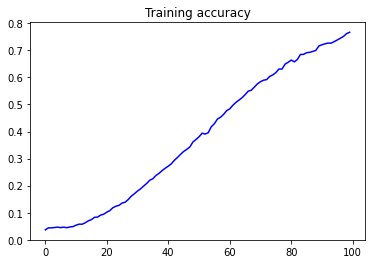

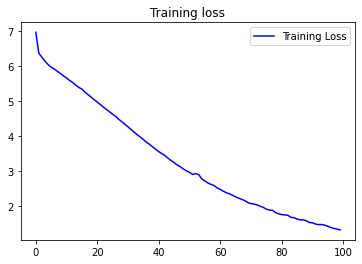

In [50]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()

In [86]:
seed_text = "ο σωκράτης είναι άνεργος"
next_words = 15
  
for _ in range(next_words):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    predicted = model.predict_classes(token_list, verbose=0)
    output_word = ""
    for word, index in tokenizer.word_index.items():
        if index == predicted:
            output_word = word
            break
    seed_text += " " + output_word

print(seed_text)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


ο σωκράτης είναι άνεργος είναι μεγάλος κι εχθρικός χρωστάς πρώτη σφαίρα στο ψέμα σου να έχω επιβάτηό σε κλειστό


In [52]:
#Save the model
model.save('greekLyrics.h5')

In [ ]:
#Load the model
model = load_model('greekLyrics.h5')